In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split



In [ ]:
start="2020-01-01"
end="2023-12-01"

In [ ]:
def clean_cols(df):

    df.columns = [c[0] for c in df.columns]
    return df

VIX=clean_cols(yf.download("^VIX",start, end))
sp500_v=clean_cols(yf.download("^GSPC",start, end))
sp500_v.head()



/tmp/ipython-input-1093527190.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  VIX=clean_cols(yf.download("^VIX",start, end))
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1093527190.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500_v=clean_cols(yf.download("^GSPC",start, end))
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000


# I. Observation Générales

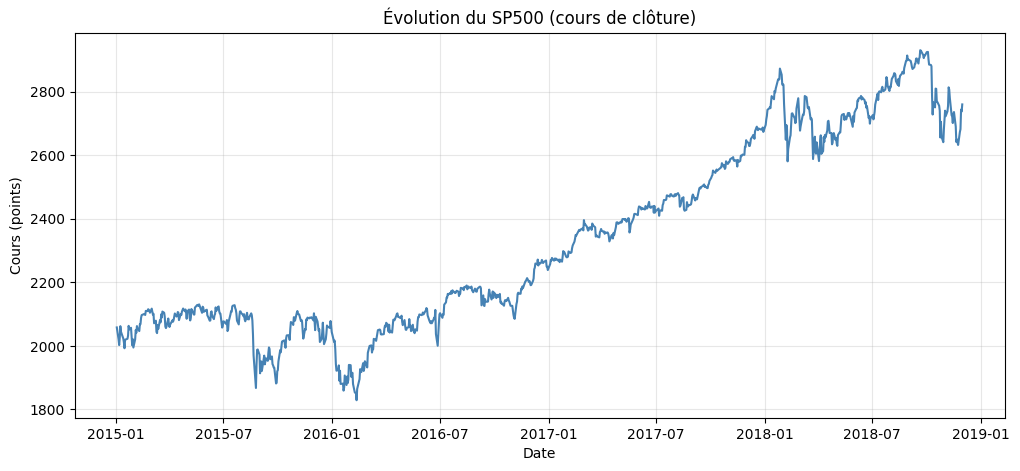

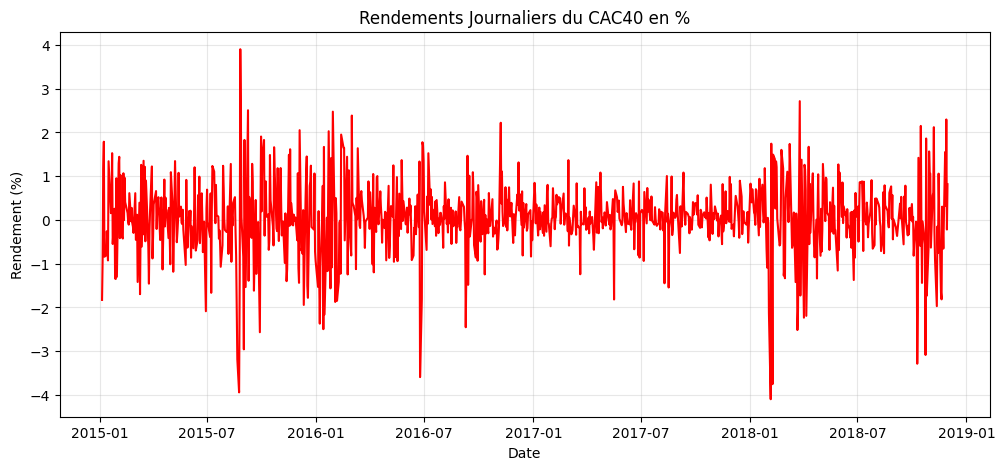

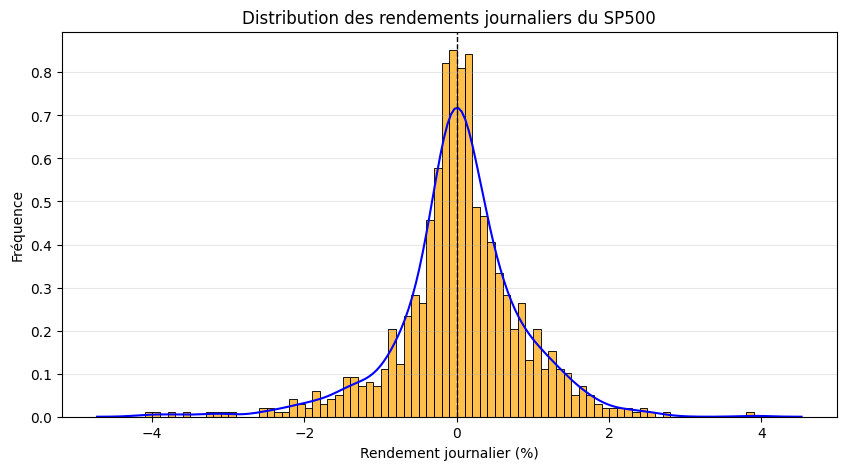

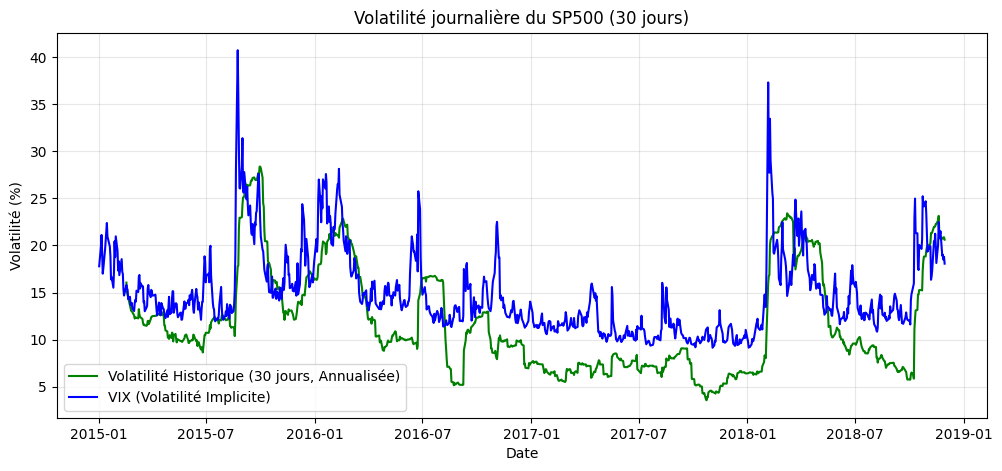

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(sp500_v["Close"], color="steelblue")
plt.title("Évolution du SP500 (cours de clôture)")
plt.xlabel("Date")
plt.ylabel("Cours (points)")
plt.grid(True, alpha=0.3)
plt.show()


#Visualisations Rendements


plt.figure(figsize=(12,5))
sp500_v["rendements"]= (sp500_v["Close"]-sp500_v["Close"].shift(1))/sp500_v["Close"].shift(1)*100
sp500_v=sp500_v.dropna()
plt.plot(sp500_v["rendements"],color="red")
plt.title("Rendements Journaliers du CAC40 en %")
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.grid(True, alpha=0.3)
plt.show()

#Histogramme avec KDE
plt.figure(figsize=(10,5))
sns.histplot(sp500_v["rendements"], bins=80, color="orange", edgecolor="black", alpha=0.7,stat="density")
sns.kdeplot(sp500_v["rendements"],color="blue",label="Densité KDE")
plt.title("Distribution des rendements journaliers du SP500")
plt.xlabel("Rendement journalier (%)")
plt.ylabel("Fréquence")
plt.grid(axis="y", alpha=0.3)
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.show()

#Volatilité

sp500_v["vol_30j"]=sp500_v["rendements"].rolling(window=30).std()* np.sqrt(252)   #On a 252 jours de bourse par an et le VIX est annualisé: On met à l'échelle
sp500_v=sp500_v.dropna()
plt.figure(figsize=(12,5))
plt.plot(sp500_v["vol_30j"], color="green", label="Volatilité Historique (30 jours, Annualisée)")
plt.title("Volatilité journalière du SP500 (30 jours)")
plt.xlabel("Date")
plt.ylabel("Volatilité (%)")
plt.grid(True, alpha=0.3)

#VIX
plt.plot(VIX["Close"], color="blue", label="VIX (Volatilité Implicite)")

plt.legend()


# II. Analyse du SP500 (sous jacent du VIX)

In [ ]:
#On récupère les infos sur le sp500 depuis un datahub
url = "https://datahub.io/core/s-and-p-500-companies/r/constituents.csv"
sp500 = pd.read_csv(url)
sp500 = sp500.drop(columns=["CIK", "Founded", "Date added", "Headquarters Location"])  #On supprime les colonnes inutiles
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services


In [ ]:
#On calcule le poids des entreprises manuellement

def get_marketcap(ticker):
  try:

      #On a 2/3 tickers qui sont différents entre le deux données, on corrige ça:
      if(ticker=="BRK.B"):
        ticker="BRK-B"
      if(ticker=="BF.B"):
        ticker="BF-B"

      info = yf.Ticker(ticker).info
      mc = info.get("marketCap", None)



      if mc is None:
          print(f"Pas de data pour {ticker}")
      return mc

  except Exception as e:
      print(f"Erreur sur {ticker}: {e}")
      return None

sp500["MarketCap"] = sp500["Symbol"].apply(get_marketcap)
total_marketcap = sp500["MarketCap"].sum()
sp500["Poids (%)"] = (sp500["MarketCap"] / total_marketcap) * 100
sp500 = sp500.sort_values("Poids (%)", ascending=False) #On trie pour faire joli

sp500.head()

On a une erreur 404 pour WBA: tant pis! ça représente uniquement 0.2% du poids environ. Le manque de cette info ne nuira donc pas à notre analyse

In [ ]:
#Camembert Poids/Secteur
poids_secteurs=sp500.groupby("GICS Sector")["Poids (%)"].sum()
plt.figure(figsize=(8,8))
plt.pie(poids_secteurs, labels=poids_secteurs.index,autopct="%1.1f%%")
plt.title("Poids des secteurs du SP500")
plt.show()

Les secteurs principaux sont: La tech, les services telecom/medias, la finance, l'industrie, la santé et "consumers discretionary qu'on va analyser plus tard.


Ces domaines dépendent de:

-L'énergie (mix électrique USA: petrole/gaz/charbon/nucléaire)
- Les matières premières (Métaux/Métaux précieux)
- Les taux directeurs (FED)
- La bonne santé de l'économie américaine car en plus d'être affectés par l'économie, ces domaines dépendent des éventuelles subventions (dur à déterminer)



In [ ]:
consumer_disc = sp500[sp500["GICS Sector"] == "Consumer Discretionary"]
poids_secteurs_consumer_disc = consumer_disc.groupby("GICS Sub-Industry")["Poids (%)"].sum()

# Regrouper les sous-industries de moins de 0.5 % (par rapport au total) dans "Autres" pour avoir un camembert moins chargé
poids = poids_secteurs_consumer_disc.copy()
autres = poids[poids < 0.5].sum()
poids = poids[poids >= 0.5]
poids["Autres"] = autres

# Camembert plus lisible
plt.figure(figsize=(7,7))
plt.pie(
    poids,
    labels=poids.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Sous-industries du secteur Consumer Discretionary (S&P 500)")
plt.tight_layout()
plt.show()

On rajoute donc l'automobile qui rejoint l'industrie et les commerces (pas les supermarchés comme wallmart ect... car on est en dans des dépenses de confort)

In [ ]:
#On prend aussi le top 10 du SP500:
top10 = sp500.sort_values("Poids (%)", ascending=False).head(10)
top10

# III Ajout de nouvelles données

In [ ]:
# Métaux
cuivre = clean_cols(yf.download("HG=F", start,end))
aluminium = clean_cols(yf.download("ALI=F", start, end))
nickel = clean_cols(yf.download("JJN", start, end))       #ETF JNN (à défaut d'avoir la donnée brute)
zinc = clean_cols(yf.download("ZNC=F", start, end))

# Métaux précieux
Or = clean_cols(yf.download("GC=F", start, end))  #Valeur refuge, elle est corrélée aux crises sur les marchés. On l'importe ici par soucis de présentation
argent = clean_cols(yf.download("SI=F", start, end))

# Énergie
petrole = clean_cols(yf.download("CL=F", start, end))
gaz = clean_cols(yf.download("NG=F", start, end))
uranium = clean_cols(yf.download("URA", start, end))       # ETF Global x Uranium (à défaut d'avoir la donnée brute)


In [ ]:
#On vérifie si tout est bien chargé
datasets = {
    "cuivre": cuivre,
    "aluminium": aluminium,
    "nickel": nickel,
    "zinc": zinc,
    "or": Or,
    "argent": argent,
    "petrole": petrole,
    "gaz": gaz,
    "uranium": uranium

}

for nom, df in datasets.items():
    if df is None or df.empty:
        print(f"{nom} : vide ou non chargé")


In [ ]:
# On vérifie si tout est bien chargé
datasets = {
    "cuivre": cuivre,
    "aluminium": aluminium,
    "nickel": nickel,
    "zinc": zinc,
    "or": Or,
    "argent": argent,
    "petrole": petrole,
    "gaz": gaz,
    "uranium": uranium
}


def rdm(df):
    df["rendements"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
    return df.dropna(inplace=True)


# Application de la fonction à tous les datasets
for nom, df in datasets.items():
    rdm(df)

Or["rendements"].head()

In [ ]:
#Pour ce qui est de la santé économique américaine, nous prendrons les obligations sur 10 ans.

oblig_10ans = clean_cols(yf.download("^TNX", start, end))

# IV Analyse de corrélation et features engineering

In [ ]:
#On Rajoute la Moyenne mobile simple (SMA: Simple Moving Average) à ne pas confondre avec la vol_30j

def SMA(df, window):
    return df.rolling(window=window).mean()


#On rajoute également l'indice de force relative (RSI: Relative Strengh Index): il mesure la vitesse et l'amplitude des variations récente de prix, ce qui est utile pour savoir si on a une forte pression à la hausse ou baisse


def RSI(data, dt):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=dt).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=dt).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi




rsi=RSI(sp500_v["Volume"],14)   #Pour le moment on prend la valeur "standard" qui équivaut à 14 jours. Néanmoins, il serait peut être intéressant de prendre une échelle de temps plus courte pour refléter la "nervosité du marché". Nous optimiseront plus tard
sma=SMA(sp500_v["Volume"],14)   #Nous prendrons également une SMA à court terme (à la même fenêtre que la rsi pour une question de cohérence et également pour les raisons énoncées en haut)
#sma : rolling moyenne somme prix / n
#rsi : pression à la hausse ou à la baisse



On crée 13 valeurs manquantes car on calcule sur une fenêtre et on fait un rolling. L'optimal serait de faire toutes les transformations (rendements, vol_30j,rsi ect...) en même temps pour ne pas trop les accumuler. Néanmoins, par souci de présentation et de lisibilité, nous laisseront le notebook tel quel. Vu le grand nombre de données, la perte est négligeable.

# Il est temps de faire nos premières mesures de corrélations:

A) Sur le prix de fermeture

In [ ]:
#Il est temps d'évaluer nos théories:

#Corrélations entre les matières premières et le VIX:
rdm(VIX)
commo_df = pd.DataFrame({
    "VIX": VIX["Close"],
    "Cuivre": cuivre["Close"],
    "Aluminium": aluminium["Close"],
    "Nickel": nickel["Close"],
    "Zinc": zinc["Close"],
    "Or": Or["Close"],
    "Argent": argent["Close"],

})


print(commo_df.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

commo_df=commo_df.dropna()


# Matrice de corrélation (sur les rendements)
corr_commo_df = commo_df.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_commo_df, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les Commodities (2020–2023): Close")
plt.tight_layout()
plt.show()

On voit des corrélations intéressantes, notamment avec le cuivre, l'argent, l'or et l'aluminium.

Argent et Or étants eux mêmes très reliés (pareil pour le cuivre et l'aluminium), on va simplifier en ne gardant que l'argent et le cuivre.

B) Sur les rendements

In [ ]:


#Corrélations entre les matières premières et le VIX:
rdm(VIX)
commo_df_rdm = pd.DataFrame({
    "VIX": VIX["rendements"],
    "Cuivre": cuivre["rendements"],
    "Aluminium": aluminium["rendements"],
    "Nickel": nickel["rendements"],
    "Zinc": zinc["rendements"],
    "Or": Or["rendements"],
    "Argent": argent["rendements"],

})


print(commo_df_rdm.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

commo_df_rdm=commo_df_rdm.dropna()


# Matrice de corrélation (sur les rendements)
corr_commo_df_rdm = commo_df_rdm.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_commo_df_rdm, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les Commodities (2020–2023): Rendements")
plt.tight_layout()
plt.show()


On remarque que le prix de fermeture indique des corrélations intéressantes alors que le rendement en indique des quasi nulles: C'est tout à fait normal!

Le rendement qui représente les variations journalières est souvent chaotique, suivant une loi normale (voir visualisations en début de page). Ainsi, il n'est pas surprenant de ne rien trouver (ça serait trop beau :'( )

Néanmoins le prix (celui de cloture), bien que possédant une corrélation gonflée (due à une tendance commune puisqu'on est sur un marché global): mais ce n'est donc pas quelque chose à négligler. En plus, il contient de la donnée historique (présente plus ou moins dans la tête des investisseurs).

Néanmoins, cela va peut être biaiser le modèle. Nous corrigeront cela si nécessaire

# On fait de même avec l'énergie:

In [ ]:
#Corrélations entre les matières premières et le VIX:
energie_df_rdm = pd.DataFrame({
    "VIX": VIX["rendements"],
    "Petrole": petrole["rendements"],
    "Gaz": gaz["rendements"],
    "Uranium": uranium["rendements"],

})


print(energie_df_rdm.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

energie_df_rdm=energie_df_rdm.dropna()


# Matrice de corrélation (sur les rendements)
corr_energie_df_rdm = energie_df_rdm.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_energie_df_rdm, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les matières premières liées à l'énergie (2020–2023): Rendements")
plt.tight_layout()
plt.show()

In [ ]:
energie_df = pd.DataFrame({
    "VIX": VIX["Close"],
    "Petrole": petrole["Close"],
    "Gaz": gaz["Close"],
    "Uranium": uranium["Close"],

})


print(energie_df.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

energie_df=energie_df.dropna()


# Matrice de corrélation (sur le close)
corr_energie_df = energie_df.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_energie_df, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les matières premières liées à l'énergie (2020–2023): Close")
plt.tight_layout()
plt.show()

On note un lien intéressant avec l'uranium, même dans les rendements!: Peut être parce que c'est un ETF sur l'industrie en elle même?

On le garde

In [ ]:
#Corrélations entre les obligations et le VIX
rdm(oblig_10ans)
gouvernement_df_rdm = pd.DataFrame({
    "VIX": VIX["rendements"],
    "Oblig": oblig_10ans["rendements"]})


print(gouvernement_df_rdm.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

gouvernement_df_rdm=gouvernement_df_rdm.dropna()


# Matrice de corrélation (sur les rendements)
corr_gouvernement_df_rdm = gouvernement_df_rdm.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_gouvernement_df_rdm, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les obligations US 10 ans (2020–2023): Rendements")
plt.tight_layout()
plt.show()

In [ ]:

gouvernement_df= pd.DataFrame({
    "VIX": VIX["Close"],
    "Oblig": oblig_10ans["Close"]})


print(gouvernement_df.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

gouvernement_df=gouvernement_df.dropna()


# Matrice de corrélation (sur le close)
corr_gouvernement_df = gouvernement_df.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_gouvernement_df, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les obligations US 10 ans (2020–2023): Close")
plt.tight_layout()
plt.show()

On tient un filon, mais c'est pas trop ça. Essayons de prendre une maturité plus faible pour avoir une idée de l'impact des décisions récentes:

Prenons les 3 month treasury bills

In [ ]:
oblig_3mois=clean_cols(yf.download("^IRX", start, end))
#Corrélations entre les obligations et le VIX
rdm(oblig_3mois)
gouvernement2_df_rdm = pd.DataFrame({
    "VIX": VIX["Close"],
    "Oblig": oblig_3mois["Close"]})


print(gouvernement2_df_rdm.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

gouvernement2_df_rdm=gouvernement2_df_rdm.dropna()


# Matrice de corrélation (sur les rendements)
corr_gouvernement2_df_rdm = gouvernement2_df_rdm.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_gouvernement2_df_rdm, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et les obligations US 10 ans (2020–2023): Rendements")
plt.tight_layout()
plt.show()

Avec le SP500:

In [ ]:
#Corrélations entre le SP500 et le VIX:
sp500_df = pd.DataFrame({
    "VIX": VIX["Close"],
    "SP500": sp500_v["Close"],
    "SP500 Vol": sp500_v["Volume"],
    "SP500 SMA": sma,
    "SP500 RSI": rsi})



print(sp500_df.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

sp500_df=sp500_df.dropna()


# Matrice de corrélation
corr_sp500 = sp500_df.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_sp500, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et le SP500 (2020–2023)")
plt.tight_layout()
plt.show()

On importe également le VVIX (vol implice du VIX)

In [ ]:
VVIX=clean_cols(yf.download("^VVIX", start, end))

VVIX_df=pd.DataFrame(
{
    "VIX": VIX["Close"],
    "VVIX": VVIX["Close"]
})


print(sp500_df.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

VVIX_df=VVIX_df.dropna()


# Matrice de corrélation
corr_VVIX = VVIX_df.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_VVIX, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et le VVIX (2020–2023)")
plt.tight_layout()
plt.show()




In [ ]:
rdm(VVIX)
VVIX_df=pd.DataFrame(
{
    "VIX": VIX["rendements"],
    "VVIX": VVIX["rendements"]
})


print(sp500_df.isna().sum())
#On a quelques valeurs manquantes mais rien de bien méchant par rapport au nombre de lignes totales, on supprime.

VVIX_df=VVIX_df.dropna()


# Matrice de corrélation
corr_VVIX = VVIX_df.corr()

# Heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(corr_VVIX, annot=True, cmap="coolwarm", center=0)
plt.title("Corrélation entre le VIX et le VVIX (2020–2023): Rendements")
plt.tight_layout()
plt.show()

